# **Imports**



In [ ]:
!pip install pytesseract


In [ ]:
import numpy as np
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import pytesseract

# **Image preprocessing**

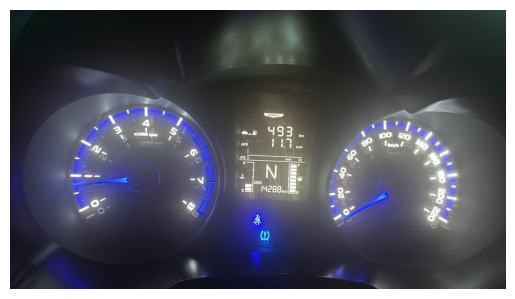

In [ ]:
img = cv2.imread('/content/drive/MyDrive/ubi_img/dashboard.jpg')
plt.imshow(img)
plt.axis("off")
plt.show()


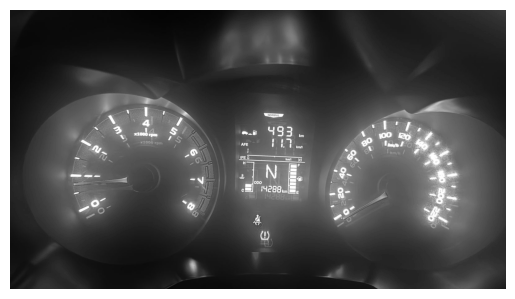

In [ ]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap='gray')
plt.axis("off")
plt.show()

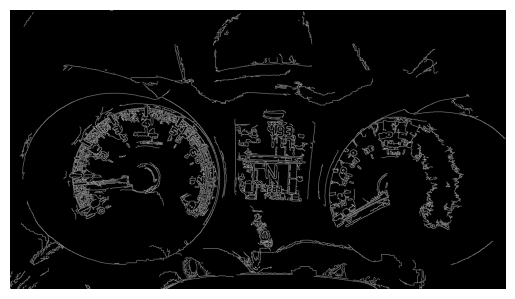

In [ ]:
img_blur = cv2.GaussianBlur(img_gray, (3,3), 0)
enhanced = cv2.equalizeHist(img_blur)
edges = cv2.Canny(enhanced, 50, 10)
plt.imshow(edges, cmap='gray')
plt.axis("off")
plt.show()

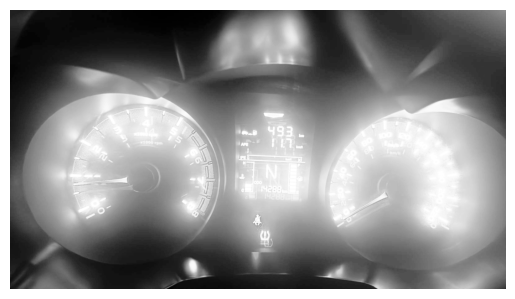

In [ ]:
plt.imshow(enhanced, cmap='gray')
plt.axis("off")
plt.show()

# **Reading analog dials**

In [ ]:
def map_angle_to_speed(angle):
    min_angle = -30
    max_angle = 210
    min_speed = 0
    max_speed = 220

    if angle < min_angle:
        angle = min_angle
    elif angle > max_angle:
        angle = max_angle

    speed = ((angle - min_angle) / (max_angle - min_angle)) * (max_speed - min_speed) + min_speed
    return speed

In [ ]:
def map_angle_to_rpm(angle):
    min_angle = -30
    max_angle = 210
    min_rpm = 0
    max_rpm = 8

    if angle < min_angle:
        angle = min_angle
    elif angle > max_angle:
        angle = max_angle

    rpm = ((angle - min_angle) / (max_angle - min_angle)) * (max_rpm - min_rpm) + min_rpm
    return rpm

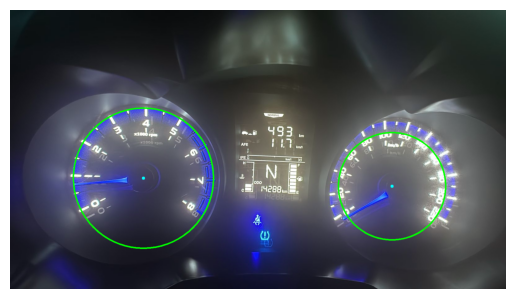

In [ ]:
circles = cv2.HoughCircles(img_blur, cv2.HOUGH_GRADIENT, dp=0.5, minDist=100,
                           param1=100, param2=50, minRadius=120, maxRadius=250)

# Ensure that some circles have been found
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(img, (x, y), r, (0, 255, 0), 4)
        cv2.circle(img, (x, y), 5, (0, 255, 255), -1)
else:
    print("None")
plt.imshow(img)
plt.axis('off')
plt.show()


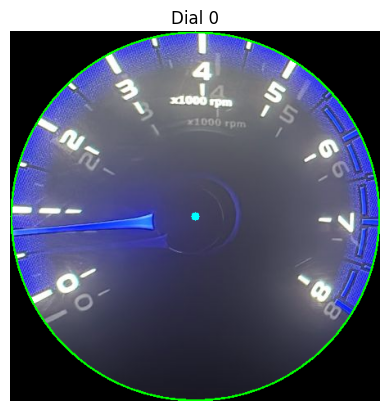

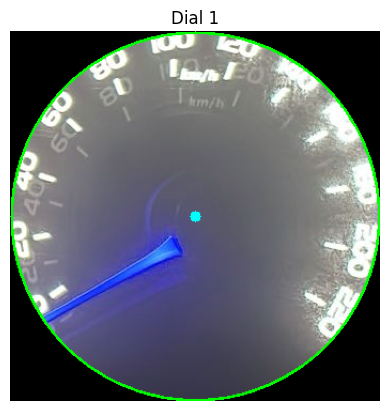

In [ ]:
dials = []

for i, (x, y, r) in enumerate(circles):
    mask = np.zeros_like(img_gray)
    cv2.circle(mask, (x, y), r, (255, 255, 255), thickness=-1)

    masked_img = cv2.bitwise_and(img, img, mask=mask)
    circle_crop = masked_img[y-r:y+r, x-r:x+r]
    dials.append(circle_crop)

final_dials=[]

for i in range(0,2):
  final_dials.append(dials[i]);
  plt.imshow(dials[i])
  plt.title(f"Dial {i}")
  plt.axis("off")
  plt.show()

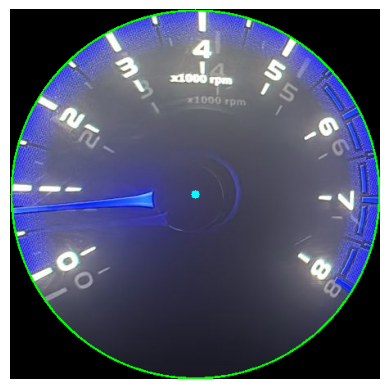

In [ ]:
newimg = final_dials[0].copy()
plt.imshow(newimg)
plt.axis("off")
plt.show()
save_dir = "/content/drive/MyDrive/ubi_img"

Line: (1, 242) -> (139, 230), Length: 138.52, Angle: -4.97 degrees
Current RPM: 834.3419757296566


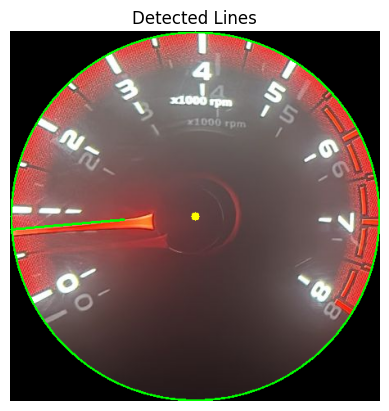

In [ ]:
gray_1 = cv2.cvtColor(final_dials[0], cv2.COLOR_BGR2GRAY)

gray_blurred = cv2.GaussianBlur(gray_1, (5, 5), 0)

# Use Canny edge detection with lower thresholds
edges_1 = cv2.Canny(gray_blurred, 50, 150, apertureSize=3)

# Detect lines using Hough Line Transform
lines = cv2.HoughLinesP(edges_1, 1, np.pi / 180, threshold=80, minLineLength=120, maxLineGap=10)

if lines is not None:
    max_line_length = 150
    for line in lines:
        x1, y1, x2, y2 = line[0]
        line_length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

        if line_length <= max_line_length:
            cv2.line(newimg, (x1, y1), (x2, y2), (0, 255, 0), 2)
            dx = x2 - x1
            dy = y2 - y1
            angle_radians = math.atan2(dy, dx)
            angle_degrees = math.degrees(angle_radians)
            print(f"Line: ({x1}, {y1}) -> ({x2}, {y2}), Length: {line_length:.2f}, Angle: {angle_degrees:.2f} degrees")
            calculated_rpm = map_angle_to_rpm(angle_degrees)*1000
            print("Current RPM:", calculated_rpm)

    plt.imshow(cv2.cvtColor(newimg, cv2.COLOR_BGR2RGB))
    plt.title("Detected Lines")
    plt.axis("off")
    plt.savefig("/content/drive/MyDrive/ubi_img/rpm.png", bbox_inches='tight', pad_inches=0)
    plt.show()
else:
    print("No lines were detected.")

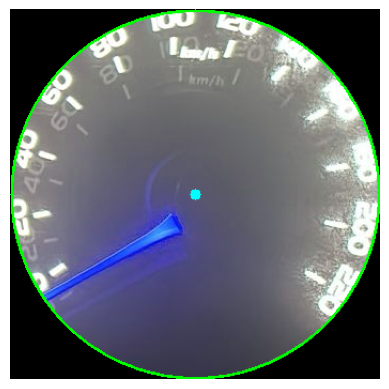

In [ ]:
speed = final_dials[1].copy()
plt.imshow(speed)
plt.axis("off")
plt.show()

Line: (28, 267) -> (133, 206), Length: 121.43, Angle: -30.15 degrees
Current speed: 0.0


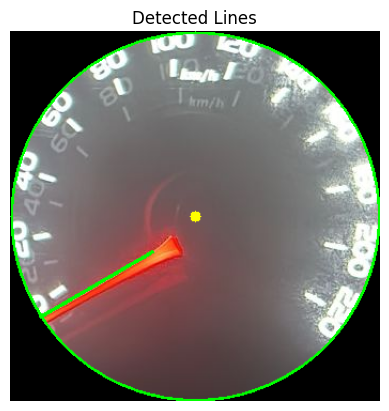

In [ ]:
gray_1 = cv2.cvtColor(final_dials[1], cv2.COLOR_BGR2GRAY)

gray_blurred = cv2.GaussianBlur(gray_1, (5, 5), 0)

# Use Canny edge detection with lower thresholds
edges_1 = cv2.Canny(gray_blurred, 50, 150, apertureSize=3)

# Detect lines using Hough Line Transform
lines = cv2.HoughLinesP(edges_1, 1, np.pi / 180, threshold=80, minLineLength=101, maxLineGap=10)

if lines is not None:
    max_line_length = 150
    for line in lines:
        x1, y1, x2, y2 = line[0]
        line_length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

        if line_length <= max_line_length:
            cv2.line(speed, (x1, y1), (x2, y2), (0, 255, 0), 2)
            dx = x2 - x1
            dy = y2 - y1
            angle_radians = math.atan2(dy, dx)
            angle_degrees = math.degrees(angle_radians)
            print(f"Line: ({x1}, {y1}) -> ({x2}, {y2}), Length: {line_length:.2f}, Angle: {angle_degrees:.2f} degrees")
            print("Current speed:", map_angle_to_speed(angle_degrees)*1000)

    plt.imshow(cv2.cvtColor(speed, cv2.COLOR_BGR2RGB))
    plt.title("Detected Lines")
    plt.axis("off")
    plt.savefig("/content/drive/MyDrive/ubi_img/speed.png", bbox_inches='tight', pad_inches=0)
    plt.show()
else:
    print("No lines were detected.")

# **Template matching for Indicator**

In [ ]:
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    gray = cv2.GaussianBlur(gray, (3, 3), 0)  # Apply slight blur to reduce noise
    return gray

In [ ]:
def match_template(image, template, method=cv2.TM_CCOEFF_NORMED):
    image_gray = preprocess_image(image)
    template_gray = preprocess_image(template)

    result = cv2.matchTemplate(image_gray, template_gray, method)

    # Get the max or min value and location based on the matching method
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        min_val, _, min_loc, _ = cv2.minMaxLoc(result)
        return min_val, min_loc
    else:
        _, max_val, _, max_loc = cv2.minMaxLoc(result)
        return max_val, max_loc

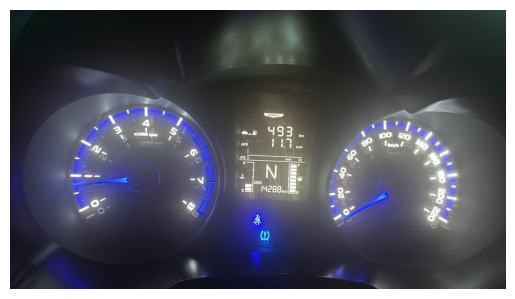

In [ ]:
img1 = cv2.imread('/content/drive/MyDrive/ubi_img/dashboard.jpg')
plt.imshow(img1)
plt.axis("off")
plt.show()

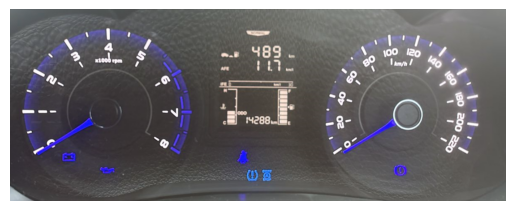

In [ ]:
img2 = cv2.imread('/content/drive/MyDrive/ubi_img/dashboard2.png')
plt.imshow(img2)
plt.axis("off")
plt.show()

In [ ]:
def get_blur(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(gray, (3, 3), 0)
  return blur

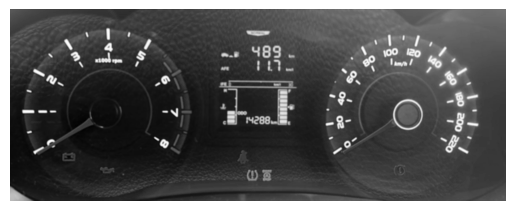

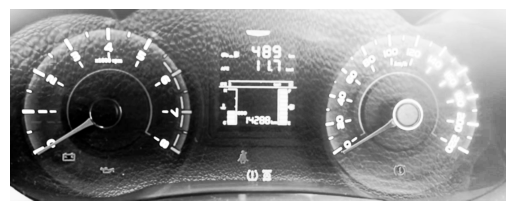

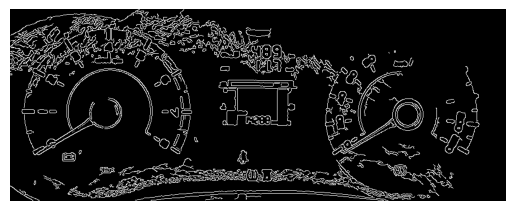

In [ ]:
blurred = get_blur(img2)
plt.imshow(blurred, cmap='gray')
plt.axis("off")
plt.show()
enhanced = cv2.equalizeHist(blurred)
plt.imshow(enhanced, cmap='gray')
plt.axis("off")
plt.show()
edges = cv2.Canny(enhanced, 200, 70)
plt.imshow(edges, cmap='gray')
plt.axis("off")
plt.show()

In [ ]:
image = img1.copy()

In [ ]:
icons = {
    "seatbelt"

}

In [ ]:
for icon_name in icons:
    img1 = image.copy()
    template = cv2.imread(f'/content/drive/MyDrive/ubi_img/{icon_name}.png', cv2.IMREAD_GRAYSCALE)
    confidence, location = match_template(img1, template)
    print(f"Matching {icon_name}: confidence = {confidence*100}%, location = {location}")
    h, w = template.shape[:2]
    top_left = location
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(img1, top_left, bottom_right, (255, 0, 0), 2)
    if confidence > 0.6:
      label = f"{icon_name}: ON ({confidence*100:.2f}%)"
    else:
      label = f"{icon_name}: OFF"
    label_position = (top_left[0], top_left[1] - 10)
    print(label_position)
    img_labelled = cv2.putText(
      img1,        # Image where text will be drawn
      label,                 # The label text
      label_position,        # Position of the label (near the rectangle)
      cv2.FONT_HERSHEY_SIMPLEX,  # Font style
      1,                     # Font scale (size of the text)
      (255, 0, 0),           # Text color (BGR format)
      2,                     # Thickness of the text
      cv2.LINE_AA            # Line type for smoother text
    )

Matching seatbelt: confidence = 78.23054790496826%, location = (784, 660)
(784, 650)


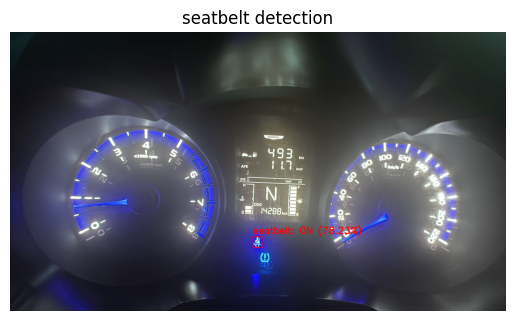

In [ ]:
plt.imshow(img1)
plt.axis("off")
plt.title("seatbelt detection")
plt.savefig("/content/drive/MyDrive/ubi_img/seatbelt_detect.png", bbox_inches = "tight", pad_inches= 0)
plt.show()